# Machine Learning

## EDA

In [25]:

import pandas as pd

train = pd.read_csv('MLUnige2023_subscriptions_train.csv')
test = pd.read_csv('MLUnige2023_subscriptions_test.csv')

In [26]:
train.head()

,Id,age,job,marital,education,device,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,outcome_old,X1,X2,X3,X4,subscription
0,0,28,freelance,married,grad_school,smartphone,4,2,26.80,3,4,196,failure,0,0,1,0.072803,1
1,1,48,industrial_worker,married,university,smartphone,30,4,13.05,1,1,79,success,0,0,0,0.075454,1
2,2,27,teacher,married,university,smartphone,14,7,8.10,3,0,-1,na,0,1,1,0.068110,0
3,3,44,unemployed,divorced,university,smartphone,13,5,7.10,2,1,369,other,0,0,1,0.091942,0
4,4,29,manager,single,grad_school,smartphone,26,4,15.90,2,2,143,success,0,0,0,0.085922,1


In [27]:
descr = train.describe()
descr

,Id,age,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,X1,X2,X3,X4,subscription
count,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000,8952.000000
mean,4475.500000,41.201743,15.663762,6.207328,17.130306,2.540550,0.759160,49.403262,0.141086,0.013963,0.496984,0.086603,0.416443
std,2584.364138,11.638321,8.379622,2.509444,16.902741,2.824065,2.099277,107.365840,0.348129,0.117345,0.500019,0.030253,0.492996
min,0.000000,18.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2237.750000,32.000000,8.000000,5.000000,6.100000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.073891,0.000000
50%,4475.500000,39.000000,16.000000,6.000000,11.450000,2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.077661,0.000000
75%,6713.250000,49.000000,21.000000,8.000000,22.500000,3.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.087768,1.000000
max,8951.000000,95.000000,31.000000,12.000000,245.400000,63.000000,58.000000,854.000000,1.000000,1.000000,1.000000,0.810043,1.000000


In [28]:
import seaborn as sns

numeric_columns = [
    'age',
    'day',
    'month',
    'time_spent',
    'banner_views',
    'banner_views_old',
    'days_elapsed_old',
    'X4',
]
g = sns.PairGrid(train[numeric_columns])
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7f136136b010> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7f1340be08b0> (for post_execute):



KeyboardInterrupt



Provided chart represents that features such as time_spent, banner_views, banner_views_old, days_elapsed_old and X4 have exponential distribution with long and thin tale.

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 8))
all_numeric_columns = [col for col in descr if col != 'Id']
corr = train[all_numeric_columns].corr()
sns.heatmap(corr)

In [ ]:
print(corr['banner_views_old']['days_elapsed_old'])

In [ ]:
print(corr['subscription']['time_spent'])

As we can see, the subscription is highly correlated with time_spent. So, we expect this feature to be very important in our prediction.

<Axes: xlabel='banner_views_old', ylabel='time_spent'>

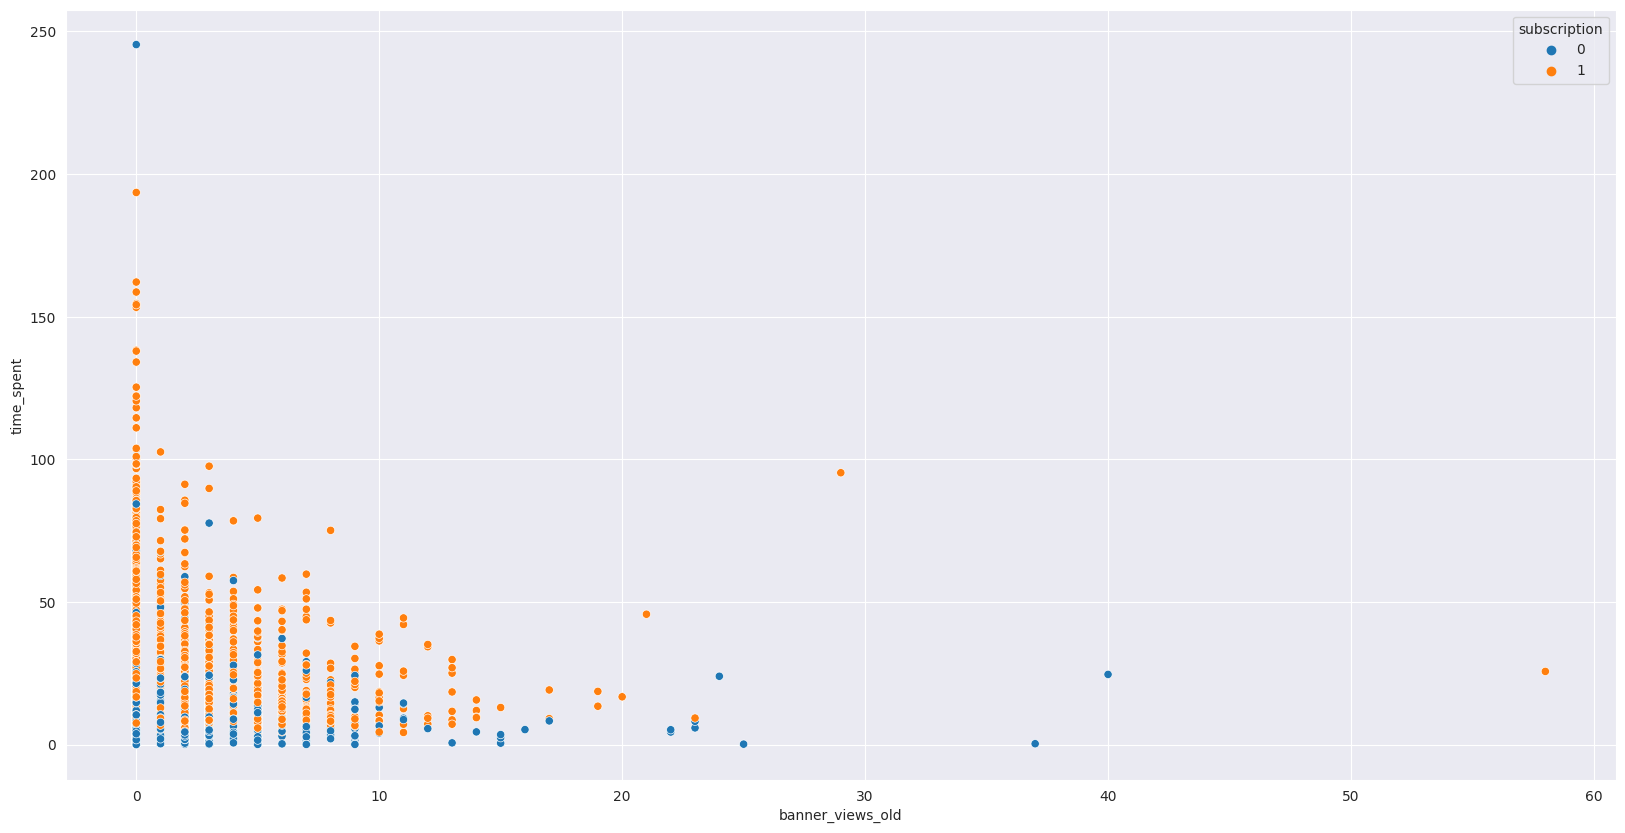

In [9]:
fig = plt.figure(figsize=(20, 10))
sns.scatterplot(
    data=train,
    x='banner_views_old',
    y='time_spent',
    hue='subscription',
)

According to the chart people with lower time_spent a less likely to buy subscription, that match the positive correlation between features.

Let's have a look on the categorical variables

In [10]:
categorical_columns = ['job', 'marital', 'education', 'device', 'outcome_old']
for column in categorical_columns:
    print(f'{column}: {train[column].unique()}')

job: ['freelance' 'industrial_worker' 'teacher' 'unemployed' 'manager'
 'salesman' 'technology' 'retired' 'student' 'housekeeper' 'entrepreneur'
 'na']
marital: ['married' 'divorced' 'single']
education: ['grad_school' 'university' 'high_school' 'na']
device: ['smartphone' 'na' 'desktop']
outcome_old: ['failure' 'success' 'na' 'other']


## Necessary functions

In [32]:
from tqdm import tqdm


def encode_categorical_features(
        data,
        categorical_columns,
        predict_na,
        is_train,
        extra_data=None,
        drop_columns=True
):
    for col in tqdm(categorical_columns):
        if predict_na and 'na' in data[col].unique():
            if extra_data is not None:
                full_data = pd.concat([data, extra_data]).reset_index(
                    drop=True)
            else:
                full_data = data
            pred, na_index = predict_na(
                dataframe=full_data,
                column=col,
                is_train=is_train
            )
            data[f'{col}_is_na'] = data[col] == 'na'
            data.loc[na_index, col] = pred[:len(data)]

        new_cols = pd.get_dummies(data[col])
        if 'na' in new_cols.columns:
            new_cols = new_cols.drop(columns=['na'])
        else:
            new_cols = new_cols[new_cols.columns[:-1]]
        columns = [f'{col}_{column}' for column in new_cols.columns]
        data[columns] = new_cols
    if drop_columns:
        data.drop(columns=categorical_columns, inplace=True)

In [33]:
predictor_models = dict()


def predict_na(
        dataframe,
        column,
        is_train,
        model_class=None,
        model_params=None
):
    if model_params is None:
        model_params = {}
    if model_class is None:
        model_class = CatBoostClassifier
        model_params['verbose'] = False
    columns_to_drop = ['Id'] + categorical_columns + [column]
    if 'subscription' in dataframe.columns:
        columns_to_drop.append('subscription')
    X = dataframe.drop(columns=columns_to_drop)
    y = dataframe[column]
    na_index = y == 'na'
    X_train = X[~na_index]
    y_train = y[~na_index]
    if is_train:
        model = model_class(**model_params)
        model.fit(X_train, y_train)
        predictor_models[(column, model_class.__name__)] = model
    else:
        model = predictor_models[(column, model_class.__name__)]
    pred = model.predict(X[na_index])
    return pred, na_index

In [34]:
from datetime import datetime


def transform_data(
        data,
        predict_na,
        is_train,
        categorical_columns,
        add_weekday=False,
        transform_days_elapsed_old=False
):
    dataframe = data.copy(deep=True)
    if add_weekday:
        if 'weekday_2021' not in categorical_columns:
            categorical_columns = list(categorical_columns)
            categorical_columns.append('weekday_2021')
        dataframe['weekday_2021'] = dataframe[['month', 'day']].apply(
            lambda row: datetime(2021, row['month'], row['day']).weekday(),
            axis=1)

    encode_categorical_features(
        dataframe,
        categorical_columns,
        predict_na=predict_na,
        is_train=is_train
    )
    if transform_days_elapsed_old:
        dataframe.loc[
            dataframe['days_elapsed_old'] == -1, 'days_elapsed_old'] = 365 * 3
    return dataframe


## Model 1 : Random forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Preprocess data
transformed_train = transform_data(
    train,
    predict_na=False,
    is_train=True,
    categorical_columns=categorical_columns
)

# Separate features from labels
X_train = transformed_train.drop(columns=['subscription'])
y_train = transformed_train['subscription']

# Split the data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42
)

100%|██████████| 5/5 [00:00<00:00, 215.48it/s]


In [15]:
# Initialize the random forest classifier
rf = RandomForestClassifier(random_state=42)

# Define a grid for the hyperparameter search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform a grid search
grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=True
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

# Retrieve the best model
best_rf = grid_search.best_estimator_

# Train and predict using the model with the best parameters
modelrf = RandomForestClassifier(**best_params)
modelrf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters:  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestClassifier(min_samples_leaf=2)

In [16]:
predict_test = modelrf.predict(X_test)
predict_train = modelrf.predict(X_train)

accuracy_train = round(accuracy_score(y_train, predict_train), 6)
accuracy_test = round(accuracy_score(y_test, predict_test), 6)
print(f'{accuracy_train=}\n{accuracy_test=}')

accuracy_train=0.973048
accuracy_test=0.844779


## Model 2 : XGboost

In [37]:
from xgboost import XGBClassifier

# Create a XGBClassifier model
model = XGBClassifier(
    objective='binary:logistic',  # this is for binary classification
)

# Define a grid for the hyperparameter search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200, 500]
}

# Perform a grid search
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=True
)

# Fit the grid_search to the training data
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [38]:
from sklearn.metrics import accuracy_score

predict_test = best_xgb.predict(X_test)
predict_train = best_xgb.predict(X_train)

accuracy_train = round(accuracy_score(y_train, predict_train), 3)
accuracy_test = round(accuracy_score(y_test, predict_test), 3)
print(f'{accuracy_train=}\n{accuracy_test=}')

accuracy_train=0.932
accuracy_test=0.861


## Model 3 : CatBoost

In [40]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

model = CatBoostClassifier()

model.fit(X_train, y_train)

Learning rate set to 0.023879
0:	learn: 0.6789855	total: 51.8ms	remaining: 51.7s
1:	learn: 0.6651288	total: 54ms	remaining: 26.9s
2:	learn: 0.6518169	total: 56ms	remaining: 18.6s
3:	learn: 0.6393324	total: 57.9ms	remaining: 14.4s
4:	learn: 0.6279288	total: 59.8ms	remaining: 11.9s
5:	learn: 0.6169150	total: 61.7ms	remaining: 10.2s
6:	learn: 0.6074835	total: 63.5ms	remaining: 9.01s
7:	learn: 0.5994461	total: 65.4ms	remaining: 8.1s
8:	learn: 0.5904074	total: 67.3ms	remaining: 7.41s
9:	learn: 0.5822112	total: 69.3ms	remaining: 6.86s
10:	learn: 0.5725985	total: 71.4ms	remaining: 6.42s
11:	learn: 0.5633131	total: 73.4ms	remaining: 6.05s
12:	learn: 0.5566133	total: 75.6ms	remaining: 5.74s
13:	learn: 0.5498199	total: 77.6ms	remaining: 5.47s
14:	learn: 0.5419164	total: 79.8ms	remaining: 5.24s
15:	learn: 0.5351259	total: 82ms	remaining: 5.04s
16:	learn: 0.5297306	total: 84.3ms	remaining: 4.87s
17:	learn: 0.5236777	total: 86.6ms	remaining: 4.72s
18:	learn: 0.5177559	total: 88.9ms	remaining: 4.59s

In [44]:
importance = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)
importance

,importance
time_spent,24.990634
month,15.917317
day,9.188455
X4,6.601288
device_smartphone,5.834678
age,5.398455
X3,4.857732
days_elapsed_old,4.089911
banner_views,4.087171
outcome_old_success,3.914454


In [45]:
predict_test = model.predict(X_test)
predict_train = model.predict(X_train)

In [46]:
from sklearn.metrics import accuracy_score

accuracy_train = round(accuracy_score(y_train, predict_train), 3)
accuracy_test = round(accuracy_score(y_test, predict_test), 3)
print(f'{accuracy_train=}\n{accuracy_test=}')

accuracy_train=0.922
accuracy_test=0.867


## Comparing the 3 models

## Generate a Kaggle submission

In [47]:
transformed_test = transform_data(
    test,
    predict_na=False,
    is_train=False,
    categorical_columns=categorical_columns
)

100%|██████████| 5/5 [00:00<00:00, 405.09it/s]


In [ ]:
submission = test[['Id']]
submission['subscription'] = model.predict(test.drop(columns=['Id']))
submission.head()

In [ ]:
len(submission)

In [ ]:
submission.to_csv('submission.csv', index=False)